# Aplicações do Modelo Clássico de Regressão Linear

In [48]:
# Importando bibliotecas
import pandas as pd
import seaborn as sn
import numpy as np
from patsy import dmatrices
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.stats.diagnostic as dg
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [49]:
# Leitura e definição de tipos da base de dados
df = pd.read_stata('salario_stata11.dta')

# Convertendo tipos e visualizando dados
df = df.astype({
    'Sal':          'int8',
    'Exp':          'int8',
    'CursoCap':     'int8',
    'DummyMulher':  'bool',
    'Posgrad':      'int8'
})
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Sal          10 non-null     int8 
 1   Exp          10 non-null     int8 
 2   CursoCap     10 non-null     int8 
 3   DummyMulher  10 non-null     bool 
 4   Posgrad      10 non-null     int8 
dtypes: bool(1), int8(4)
memory usage: 182.0 bytes


,Sal,Exp,CursoCap,DummyMulher,Posgrad
0,15,8,0,False,1
1,20,6,1,False,2
2,20,15,0,False,2
3,40,20,1,True,3
4,50,25,2,True,3
5,25,11,1,False,2
6,10,5,0,False,1
7,55,32,3,True,1
8,35,28,1,False,2
9,30,20,1,False,2


## Análise exploratória

In [50]:
# Estatísticas descritivas
describe_int8 = df.describe(include='int8')
rounded_df = describe_int8.round(2)
describe_dummy = df.describe(include='bool')

display(rounded_df)
print('====================')
display(describe_dummy)

,Sal,Exp,CursoCap,Posgrad
count,10.00,10.00,10.00,10.00
mean,30.00,17.00,1.00,1.90
std,14.91,9.51,0.94,0.74
min,10.00,5.00,0.00,1.00
25%,20.00,8.75,0.25,1.25
50%,27.50,17.50,1.00,2.00
75%,38.75,23.75,1.00,2.00
max,55.00,32.00,3.00,3.00


,DummyMulher
count,10
unique,2
top,False
freq,7


- 0 = False = Homem
- 1 = True  = Mulher

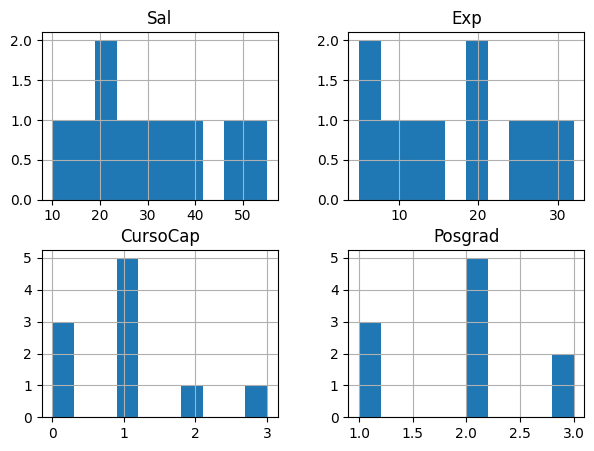

In [51]:
# Histograma
hist = df.hist(column=['Sal', 'Exp', 'CursoCap', 'Posgrad'], figsize=(7,5))

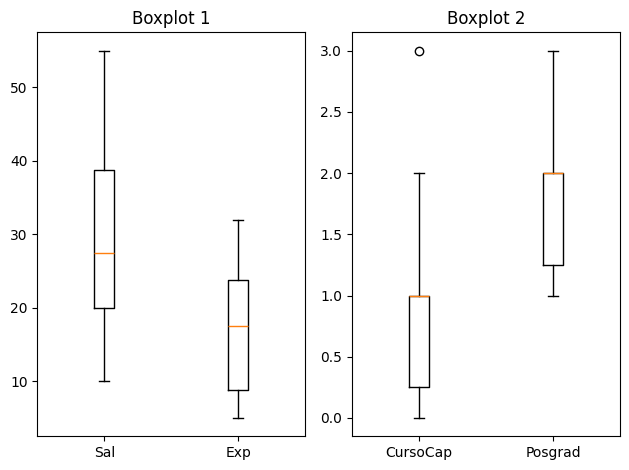

In [52]:
# Boxplot

# Criar subplots para colunas
fig, axes = plt.subplots(1, 2)

# Primeiro boxplot
axes[0].boxplot(df[['Sal', 'Exp']])
axes[0].set_title('Boxplot 1')
axes[0].set_xticks([1, 2])
axes[0].set_xticklabels(['Sal', 'Exp'])

# Segundo boxplot
axes[1].boxplot(df[['CursoCap', 'Posgrad']])
axes[1].set_title('Boxplot 2')
axes[1].set_xticks([1, 2])
axes[1].set_xticklabels(['CursoCap', 'Posgrad'])

plt.tight_layout()
plt.show()

## Modelo de regressão

In [53]:
# Ajuste e Resultados do modelo de regressão
fit = smf.ols('Sal ~ Exp + CursoCap + DummyMulher + Posgrad', data=df).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    Sal   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     374.9
Date:                Tue, 19 Nov 2024   Prob (F-statistic):           2.22e-06
Time:                        23:42:36   Log-Likelihood:                -12.146
No. Observations:                  10   AIC:                             34.29
Df Residuals:                       5   BIC:                             35.81
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.3996    

/home/herick/git/Aplicacoes-MCRL/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


O R2 ajustado de 94,4% indica que as variáveis independentes tem têm um forte poder explicativo sobre a variável dependente.

Considerando o nível de significância de 5%, pode-se rejeitar a hipótese nula do teste t para todas as variáveis. A rejeição de Ho indica que todas são significativas na explicação da variável dependente.

## Teste de multicolinearidade

### Matriz de correlação

- 0 indica ausência de correlação linear entre as variáveis.
- 1 indica uma correlação perfeita.

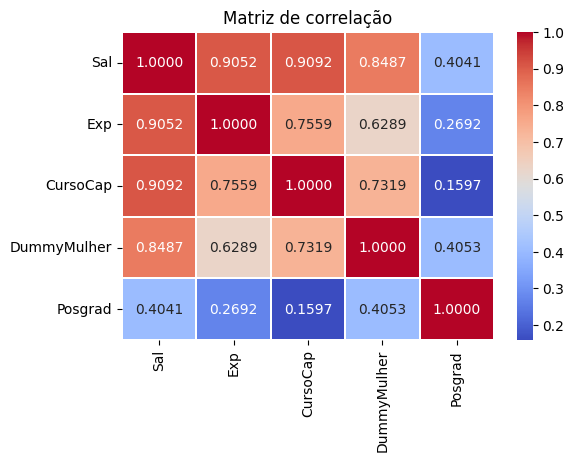

In [54]:
# Matriz de correlação
correlation = df.corr()

# plot da matriz de correlação
plt.figure(figsize=(6, 4))
plot = sn.heatmap(correlation, annot = True, fmt=".4f", linewidths=.1, cmap='coolwarm')
plt.title('Matriz de correlação')
plt.show()

### Análise dos Fatores de Inflação das Variâncias (VIF)

- VIF = 1 | Não correlacionados 
- 1 < VIF < 5 | Moderadamente correlacionados 
- VIF > 5 a 10 | Altamente correlacionados 

In [55]:
# Definindo o modelo para cálculo do VIF (Variance Inflation Factors)

# Ajustando a regressão para cálculo do VIF
y, X = dmatrices('Sal ~ Exp + CursoCap + DummyMulher + Posgrad', df, return_type='dataframe')

# Calculando VIF
vif = pd.DataFrame()
vif["Fator VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Variável"] = X.columns
vif = vif[['Variável', 'Fator VIF']]

# Visualizar VIF Factors
vif.round(1)

,Variável,Fator VIF
0,Intercept,12.4
1,DummyMulher[T.True],2.7
2,Exp,2.5
3,CursoCap,3.4
4,Posgrad,1.3


## Análise dos resíduos

Suposições primárias do Modelo de Regressão Linear 

1) Independência (entre os indivíduos): Gráfico de resíduos x indivíduo + Durbin-Watson 

2) Linearidade: Gráfico de resíduos x ^y 

3) Normalidade dos resíduos: QQ-plot + Shapiro-Wilk 

4) Homoscedasticidade dos resíduos: Gráfico de escala_locação + Breusch-Pagan

### Pressuposto da independência

In [56]:
# Executando teste Durbin-Watson
print('Estatística Durbin-Watson: ', round(durbin_watson(fit.resid), 3))

Estatística Durbin-Watson:  1.992


### Pressuposto da Linearidade

In [57]:
# Linearidade


### Pressuposto da Normalidade dos resíduos

In [58]:
# Normalidade dos Resíduos

# Teste de Shapiro-Wilk
shapiro_stat, shapiro_p_value = stats.shapiro(df['Sal'])
print('O valor da estatística de Shapiro-Wilk é: ', shapiro_stat)
print('O p-valor do teste de Shapiro-Wilk é: ', shapiro_p_value)

O valor da estatística de Shapiro-Wilk é:  0.9531151206364865
O p-valor do teste de Shapiro-Wilk é:  0.7054131178221256


### Pressuposto da Homocedasticidade

Nível de significância de 5%

- Ho: o modelo é homocedástico
- H1: o modelo é heterocedástico

In [59]:
# Teste Breusch-Pagan (Teste de heterocedasticidade)

# Executar o Teste Breusch-Pagan
names = ['Lagrange multiplier statistic', 'p-value']
 
# Obter os resultados do teste
test_result = sms.het_breuschpagan(fit.resid, fit.model.exog)

result = pd.DataFrame(list(lzip(names, test_result[0:2])), columns=['Estatística', 'Valor'])
result = result.set_index('Estatística')
result.index.name = None
result

,Valor
Lagrange multiplier statistic,7.225701
p-value,0.124431


Considerando o nível de significância de 5%, não se rejeita Ho, portanto não há problema de heterocedasticidade no modelo estimado.